In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, exp
from functools import reduce

### Notebook is based on explanations given here: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1 Written by Mehreen Saeed

In [294]:
# This is an arbitrary value
N = 100000

# Specifies how many dimensions we want to use
D = 1028

The following equations are used to encode positions

$$
P(k, 2i)=sin(\frac{k}{n^{\frac{2i}{d}}})
$$

$$
P(k, 2i + 1)=cos(\frac{k}{n^{\frac{2i}{d}}})
$$

Where
- $k$ is the position of an object within the input sequence
- $d$ is the dimensionality of the embedding space
- $n$ is a user-defined scalar (set to 10,000) by the authors of `Attention is all you need`
- $i$ is the column indices for the output coordinate. More specifically, $i$ is always within the range of $[0, d / 2]$. We use $d / 2$ for the
upper bound of the range because we calculate the odd(cosine) and even(sine) values at the same $i$.

$sin$ is used for even indices within the output coordinate, and $cos$ is used for the odd indices within the output coordinate.

In [295]:
def encode_position(k: int, d: int) -> np.ndarray[np.float64]:
  result = np.zeros(d)
  for i in range((d // 2)):
    # Calculate the first set of even and odd positions
    input = k / pow(N, (2 * i) / d)
    # Even
    result[2 * i] = sin(input)
    # Odd
    result[2 * i + 1] = cos(input)

  return result

In [296]:
def tokenize(input: str) -> list[str]:
  return input.split(' ')

In [297]:
def encode_token_positions(len: int, d: int):
  result = np.ndarray((len, d))
  for k in range(len):
    result[k] = encode_position(k, d)

  return result

In [298]:
tokens = tokenize("I am a robot what's up?")

# Use 4 dimensions for this encoding
tokens_d = 6

# Encode the tokens with a dimensionality of 4
token_positions = encode_token_positions(len(tokens), tokens_d)

# Convert to data frame and rename values
i_columns = reduce(lambda acc, cur: acc + [cur, cur], range(tokens_d // 2), list[int]())
positions_df = pd.DataFrame(token_positions, columns=i_columns)
positions_df.rename(mapper=lambda name: tokens[int(name)], inplace=True)
positions_df.rename(mapper=lambda name: f"i = {name}", axis=1, inplace=True)
positions_df

,i = 0,i = 0,i = 1,i = 1,i = 2,i = 2
I,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
am,0.841471,0.540302,0.021543,0.999768,0.000464,1.000000
a,0.909297,-0.416147,0.043075,0.999072,0.000928,1.000000
robot,0.141120,-0.989992,0.064588,0.997912,0.001392,0.999999
what's,-0.756802,-0.653644,0.086071,0.996289,0.001857,0.999998
up?,-0.958924,0.283662,0.107514,0.994204,0.002321,0.999997


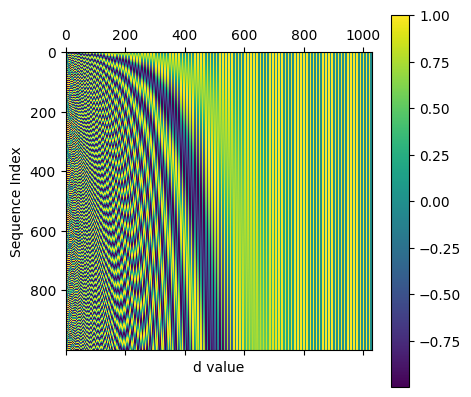

In [299]:
# Visualize
P = encode_token_positions(1000, D)
graph = plt.matshow(P)
plt.ylabel('Sequence Index')
plt.xlabel('d value')
graph.get_figure().colorbar(graph)

### Why is this useful?

Each $k$ provides us with a different sinusoid. The graph below shows $k$ with inputs from $[0,4]$ where $n = 100000$ and $d=512$:

![alt text](sinusoid-demo.gif "Title")

This means that for each token in a sequence we will always have a unique sinusoid. As a result we can guarantee the encodings are unique. In addition, the range of $sin$ and $cos$ is $[-1, 1]$ so they are already normalized. Finally, you can calculate similarity between positions which allows you to encode the relative positions of words.